<a href="https://colab.research.google.com/github/388050gomes/Churn/blob/main/Modelo_de_Previs%C3%A3o_em_empresas_de_telecomunica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREVISÃO DE ROTATIVIDADE DE CLIENTES**
*Rotatividade de clientes* ou churn representa a taxa de evasão da base de clientes das empresas, a qual é uma das métricas cruciais que uma organização pode rastrear.

<p align=center>
<img src="https://as2.ftcdn.net/v2/jpg/00/57/81/67/1000_F_57816794_HA8Uz1orKpDrp0feEzMiv7QHgYsb7AYE.jpg" width="60%"></p>

É um problema bastante grave enfrentado pelas empresas, pois mesmo que venha bater metas de vendas e contratos, se o número de cancelamentos que as empresas possuem é altíssimo.

A taxa de rotatividade tem impacto profundo nas receitas. Por isso é preciso criatividade e algumas estratégias para, se não reduzir drasticamente, lidar com essa situação.

Diante disso, um bom começo é identificar antecipadamente os potenciais clientes que pretendem cancelar seus contratos. De que forma? Usando modelo preditivo de machine learning, que será apresentado a partir de agora.

## IMPORTANTO OS DADOS 

Os dados foram disponibilizados no site da *IBM desenvolvedor*. Os dados completos podem ser acessados [aqui](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Com a finalidade de seguir os passos da execução do pandas profiling, nossa base de dados será aberta na sequência.



---



## ANÁLISE EXPLORATÓRIA DA BASE DE DADOS

Vamos conhecer e entender melhor nosso dataframe.

Para isso, vamos recorrer ao pandas profiling e outros pacotes de visualização gráfica.

In [11]:
# instalar pandas pandas profiling
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 21.9 MB 137 kB/s
     |████████████████████████████████| 102 kB 6.6 MB/s 
     |████████████████████████████████| 690 kB 36.2 MB/s 
     |████████████████████████████████| 4.7 MB 43.0 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 812 kB 39.0 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=261257 sha256=1cd2b82dfc5632db53acba7c6cfcb12a850dd118d277760ce847002e6449df8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-uhsf9isr/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=372ca8de5f283c4f229fd43819dfda35c4ca5e1b9ec77837c68cff65624ea131
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash

In [ ]:
import os
os._exit(00)

In [1]:
# importar pacotes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# importar pandas profiling
from pandas_profiling import ProfileReport

In [ ]:
# importar e abrir a base de dados
df = pd.read_csv('https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 5 primeiras entradas
df.head()

In [3]:
# Definir o profile report e salvar em html
profile = ProfileReport(df, title='data', html={'style' : {'full_width':True}})
profile.to_file(output_file='Taxa de Rotatividade.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile

Verifica-se que:

* `customerID` e `TotalCharges`tem alta cardinalidade, o que significa algo 
específico; podendo não trazer informações úteis para o treino do modelo, não servindo para novos dados. Além disso, a primeira variável não diz nada relevante. Então vamos excluir `customerID`.

* A variável `TotalCharges` está como categórica, mas é numérica, converteremos em numérica, primeiramente. Para que depois possamos analisar sua relevãncia para a variável alvo - `Churn`.

* É preciso converter as features do tipo categórica para numérica a fim de serem aproveitadas no medelo.



---



## TRATAMENTO DA BASE DE DADOS

Daqui em diante vamos fazer o tratamento dos dados em uma cópia do dataFrame.

In [4]:
# copiar DataFrame
df1 = df.copy()

In [5]:
# converter customerID de string em float
def converter_str_float(entrada):
  try:
    return float(entrada)
  except ValueError:
    return np.nan

df1['TotalCharges'] = df1['TotalCharges'].apply(converter_str_float)

# remover variável customerID
df1.drop('customerID', axis=1, inplace=True)

In [ ]:
df1.dtypes

Ao converter `TotalCharges` de string para float, verifica-se que existem valores nulos nesta coluna.

In [ ]:
# verificar valores ausentes em TotalCharges
df1['TotalCharges'].isnull().sum()

11

O qual será tratado pela mediana da referida variável.

In [6]:
# substituir dados ausentes pela mediana
TotalChargesMedian = df1['TotalCharges'].median()
df1['TotalCharges'].fillna(TotalChargesMedian, inplace= True)
df1['TotalCharges'].isnull().sum()

0

Agora falta transformar o restante das variáveis categóricas em numéricas, que serão do convertidas em dummies.

In [ ]:
# separar as variáveis categóricas das numéricas
binary_var = df1.nunique()[df1.nunique() == 2].keys().tolist()
num_var = [col for col in df1.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df1.columns.tolist() if col not in binary_var + num_var]

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df1[i] = le.fit_transform(df1[i])

# Encoding para colunas categóricas com múltiplas classes
df1 = pd.get_dummies(df1, columns=cat_var)

df1.head()

In [ ]:
df1.tail()

Assim, podemos observar como as variáveis estão se relacionando com `Churn`.

In [ ]:
# verificar correlação entre as variáveis
df1.corr()

A visualização fica melhor através do plot abaixo.

In [ ]:
plt.figure(figsize=(13, 8))
sns.heatmap(df1.corr(), cmap='hot')
plt.show()

Outro fator importante a analisarmos é a presença de outliers nas variáveis. Vejamos. Só que a grande maioria das features são variáveis binárias, dummies, a exceção de `tenure`,  `MonthlyCharges` e `TotalCharges`. Então vamos verificar nessas três variáveis.

In [8]:
# selecionar as variáveis para análise
df2 = df1[['tenure', 'MonthlyCharges', 'TotalCharges']]
df2.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [ ]:
# procurando outliers
df2.describe()

In [ ]:
# plotar box plot
sns.set(rc={'figure.figsize':(15,12)})
sns.set_theme(style='white')

ax =sns.boxplot(data=df2)

Percebemos não haver presença de valores que fogem a normalidade dos dados.

Para finalizar essa fase de tratamento dos dados, vamos recorrer novamente ao pandas profiling para nos dar informações mais detalhadas dos nosso dados numéricos, já tratados.

In [ ]:
profile1 = ProfileReport(df1, title='dados', html={'style' : {'full_width':True}})
profile1



---



## MODELO DE MACHINE LEARNING



Após passarmos pela sequência de análise e tratamento dos dados, nossa base está pronta iniciarmos a construção de nosso modelo de previsão.

Antes de iniciarmos, vamos fazer uma cópia do DataFrame. Pois será com essa cópia que iremos trabalhar no modelo preditivo.

In [10]:
df2 = df1.copy()

Seguiremos os seguintes passos:



1. Importar o modelo a ser utilizado 
2. Instanciar o modelo
3. Separar dados entre features (matriz) e target(vetor alvo)

  3.1 Dividir data set em treino e teste
  
  3.2 Padronizar dados de treino

4. Treinar o modelo - realizar fit do modelo nos dados de treino
5. Fazer previsões nos dados de teste (x_teste)
6. Visualizar os pontos previstos (x_teste) X dados reais (y_teste)
7. Avaliar o modelo



In [76]:

# 1. Importar pacotes para o modelo
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# 2. Instanciar o modelo
regressão_logistica = LogisticRegression()

# 3. Separar os dados
x = df2.drop('Churn', axis=1)
y = df2['Churn']

# 3.1 Dividir data set em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x,y)

# 3.2 Padronizar os dados de treino
scaler = StandardScaler().fit(x_train)
x_train_transformed = scaler.transform(x_train)

# 4 Treinar o modelo
regressão_logistica.fit(x_train_transformed, y_train)
#regressão_logistica.fit(x_train, y_train)

# 5. Fazer previsões nos dados de teste - x_test
x_test = scaler.transform(x_test)  # padronizar os dados de teste
y_regressão = regressão_logistica.predict(x_test)


### Confrontar pontos previstos X dados reais

Feito isso, vamos visualizar os pontos previstos versos os dados reais.

`y_regressão`   X    `y_test`

In [77]:
confusion_matrix(y_test, y_regressão)

array([[1163,  126],
       [ 223,  249]])

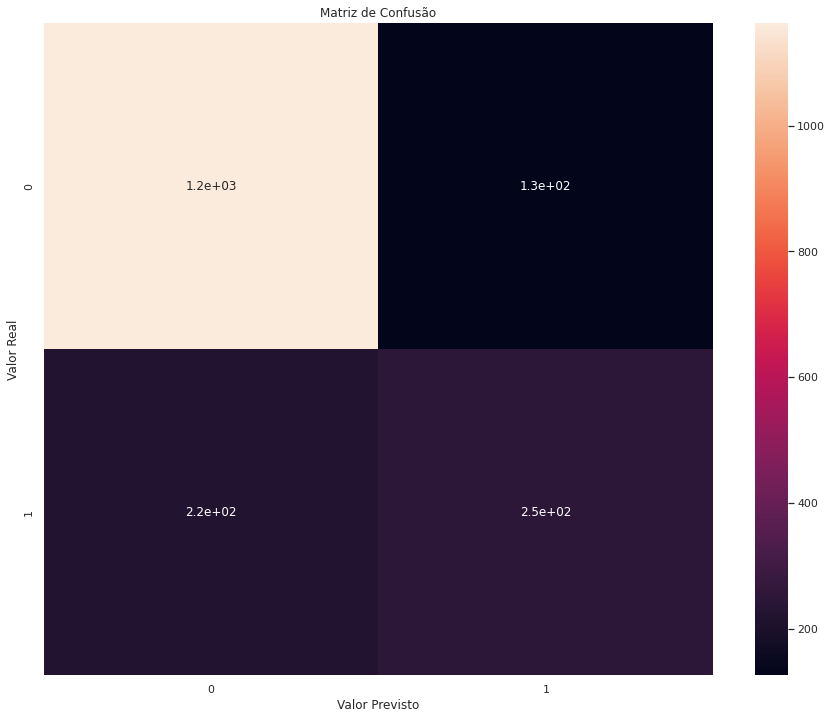

In [78]:
# Fazer plot
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_regressão), annot=True, ax=ax)

ax.set_title('Matriz de Confusão')
ax.set_ylabel('Valor Real')
ax.set_xlabel('Valor Previsto')

plt.show()


In [79]:
# probabilidades previstas pelo modelo X valor real
y_prob = regressão_logistica.predict_proba(x_test)

print("y_regressão: \n", y_regressão[0:5])
print("\ny_prob: \n", y_prob[0:5])
print('\ny_test: \n', y_test[0:5])

y_regressão: 
 [0 0 0 0 0]

y_prob: 
 [[0.94119853 0.05880147]
 [0.99583257 0.00416743]
 [0.99337661 0.00662339]
 [0.97036435 0.02963565]
 [0.57790612 0.42209388]]

y_test: 
 3720    0
4669    0
4492    0
5402    0
3493    0
Name: Churn, dtype: int64


### Avaliar o modelo

Usaremos algumas métricas para verificar o quanto o modelo é eficiente.

In [80]:
# importar métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

Começando pela **acurácia**, a qual avalia o que o modelo acertou, tanto os verdadeiros positivos (VP) quanto os verdadeiros negativos (VN). O que importa para essa métrica são os acertos do modelo em relação ao total (VP + VN + FP + FN).

In [81]:
# Acurácia
print(accuracy_score(y_test, y_regressão))

0.8018171493469619


O que interessa para a **precisão** são os valores que o modelo diz ser positivos (VP e FP), ou seja, o quanto dos valores que disse ser positivo o modelo acertou.

Precisão = VP / (VP + FP)

In [83]:
# Precisão
print(precision_score(y_test, y_regressão))

0.664


Já para o **recall** o importante são os valores positivos reais.

Recall = VP / (VP + FN)

In [84]:
# Recall
print(recall_score(y_test, y_regressão))

0.527542372881356


In [47]:
# relatório de classificação
print(classification_report(y_test, y_regressão))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1308
           1       0.64      0.54      0.58       453

    accuracy                           0.80      1761
   macro avg       0.74      0.72      0.73      1761
weighted avg       0.79      0.80      0.80      1761





---



## Considerações finais

Nem sempre encontramos de cara o modelo ideal que tenha grande eficiência, por isso é interessante fazer para outros modelos como: Random Forest, Decision Tree, dentre outros; ou utilizar outras técnicas que visam melhorar o modelo.

As métricas não têm o mesmo peso quando para avaliar o modelo, pois para determinado problema as métricas têm pesos diferentes.

